In [20]:
import os, time
from datetime import datetime
file_mtime = datetime.fromtimestamp((os.path.getmtime("README.ipynb"))).strftime("%d/%m/%Y %H:%M:%S")
comp_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

# Breaking Text-Based CAPTCHA with Convolutional Nerual Network (CNN)
**Author**: Xiurui Zhu<br />
**Modified**: {{file_mtime}}<br />
**Compiled**: {{comp_time}}

## Data preparation

Image files were loaded from the `png` files in `samples` directory.

In [32]:
import glob
img_filenames = [f for f in glob.glob("samples/*.png")]
img_filenames_count = len(img_filenames)

from matplotlib import pyplot
img_data = list(map(lambda x: pyplot.imread(x, format = "PNG"), img_filenames))

A total of {{img_filenames_count}} images were loaded. An example image was as follows:

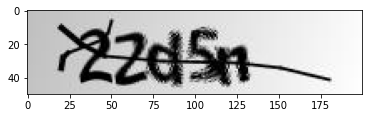

In [36]:
pyplot.imshow(img_data[1]);